### Importing Libraries

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

### Part A: Preprocessing and Initial Setup

#### 1. Data Loading

In [2]:
data,meta=arff.loadarff('yeast\yeast.arff')

In [3]:
df=pd.DataFrame(data)

In [4]:
# If string attributes are byte objects, decode them
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode("utf-8")

In [5]:
class_cols = [f'Class{i}' for i in range(1, 15)]
df[class_cols] = df[class_cols].apply(pd.to_numeric, errors='coerce')

In [6]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [7]:
df.isna().sum()

Att1       0
Att2       0
Att3       0
Att4       0
Att5       0
          ..
Class10    0
Class11    0
Class12    0
Class13    0
Class14    0
Length: 117, dtype: int64

#### 2. Dimensionality Check

In [8]:
y=df.iloc[:,-14:df.shape[1]]
X=df.iloc[:,:-14]

In [9]:
print(f"Number of features are {X.shape[1]}")
print(f"Number of data points are {X.shape[0]}")

Number of features are 103
Number of data points are 2417


#### 3. Label Selection for Visualization

In [10]:
# Calculating label frequencies and find top single labels
label_columns = y.columns.tolist()
label_counts = y.sum()
single_label_mask = y.sum(axis=1) == 1
single_label_instances = y[single_label_mask]
single_label_counts = single_label_instances.sum()
top_single_labels = single_label_counts.nlargest(2).index.tolist()

print("Top two single labels with counts:")
for label in top_single_labels:
    count = single_label_counts[label]
    print(f"  {label}: {count} instances")

Top two single labels with counts:
  Class1: 32 instances
  Class2: 0 instances


There are only 32 single label datapoints out of which all belongs to class1

In [11]:
# Finding most frequent multi-label combination
multi_label_mask = y.sum(axis=1) >= 2
multi_label_instances = y[multi_label_mask]

def get_label_combination(row):
    active_labels = []
    for label in label_columns:
        if row[label] == 1:
            active_labels.append(label)
    return tuple(sorted(active_labels))

multi_label_combinations = multi_label_instances.apply(get_label_combination, axis=1)
combination_counts = multi_label_combinations.value_counts()
most_frequent_combination = combination_counts.index[0]
most_frequent_count = combination_counts.iloc[0]

print(f"Most frequent multi-label combination: {most_frequent_combination}")
print(f"Count: {most_frequent_count} instances")

Most frequent multi-label combination: ('Class12', 'Class13', 'Class3', 'Class4')
Count: 237 instances


In [12]:
# Creating visualization categories
def assign_visualization_category(row):
    label_count = row.sum()
    if label_count == 1:
        for label in top_single_labels:
            if row[label] == 1:
                return f"Single: {label}"
    current_combination = get_label_combination(row)
    if current_combination == most_frequent_combination:
        return f"Multi: {', '.join(most_frequent_combination)}"
    return "Other"

visualization_category = y.apply(assign_visualization_category, axis=1)
category_counts = visualization_category.value_counts()
print(category_counts)

Other                                      2148
Multi: Class12, Class13, Class3, Class4     237
Single: Class1                               32
Name: count, dtype: int64


In [13]:
# creating color mapping
category_colors = {
    f"Single: {top_single_labels[0]}": 'red',
    f"Single: {top_single_labels[1]}": 'blue',
    f"Multi: {', '.join(most_frequent_combination)}": 'green',
    "Other": 'gray'
}

#### 4. Scaling

#### **Why Feature Scaling is Important**

- Features with larger numeric ranges can overpower smaller ones in distance calculations, distorting results.

-  Scaling puts all features on a comparable scale so each affects the distance measure fairly.

-  Proper scaling helps distance-based methods like  **t-SNE** capture genuine data patterns instead of being biased by units or magnitudes.


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardization completed!")
print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")

Standardization completed!
Original X shape: (2417, 103)
Scaled X shape: (2417, 103)


### Part B: t-SNE and Veracity Inspection 

#### 1. t-SNE Implementation

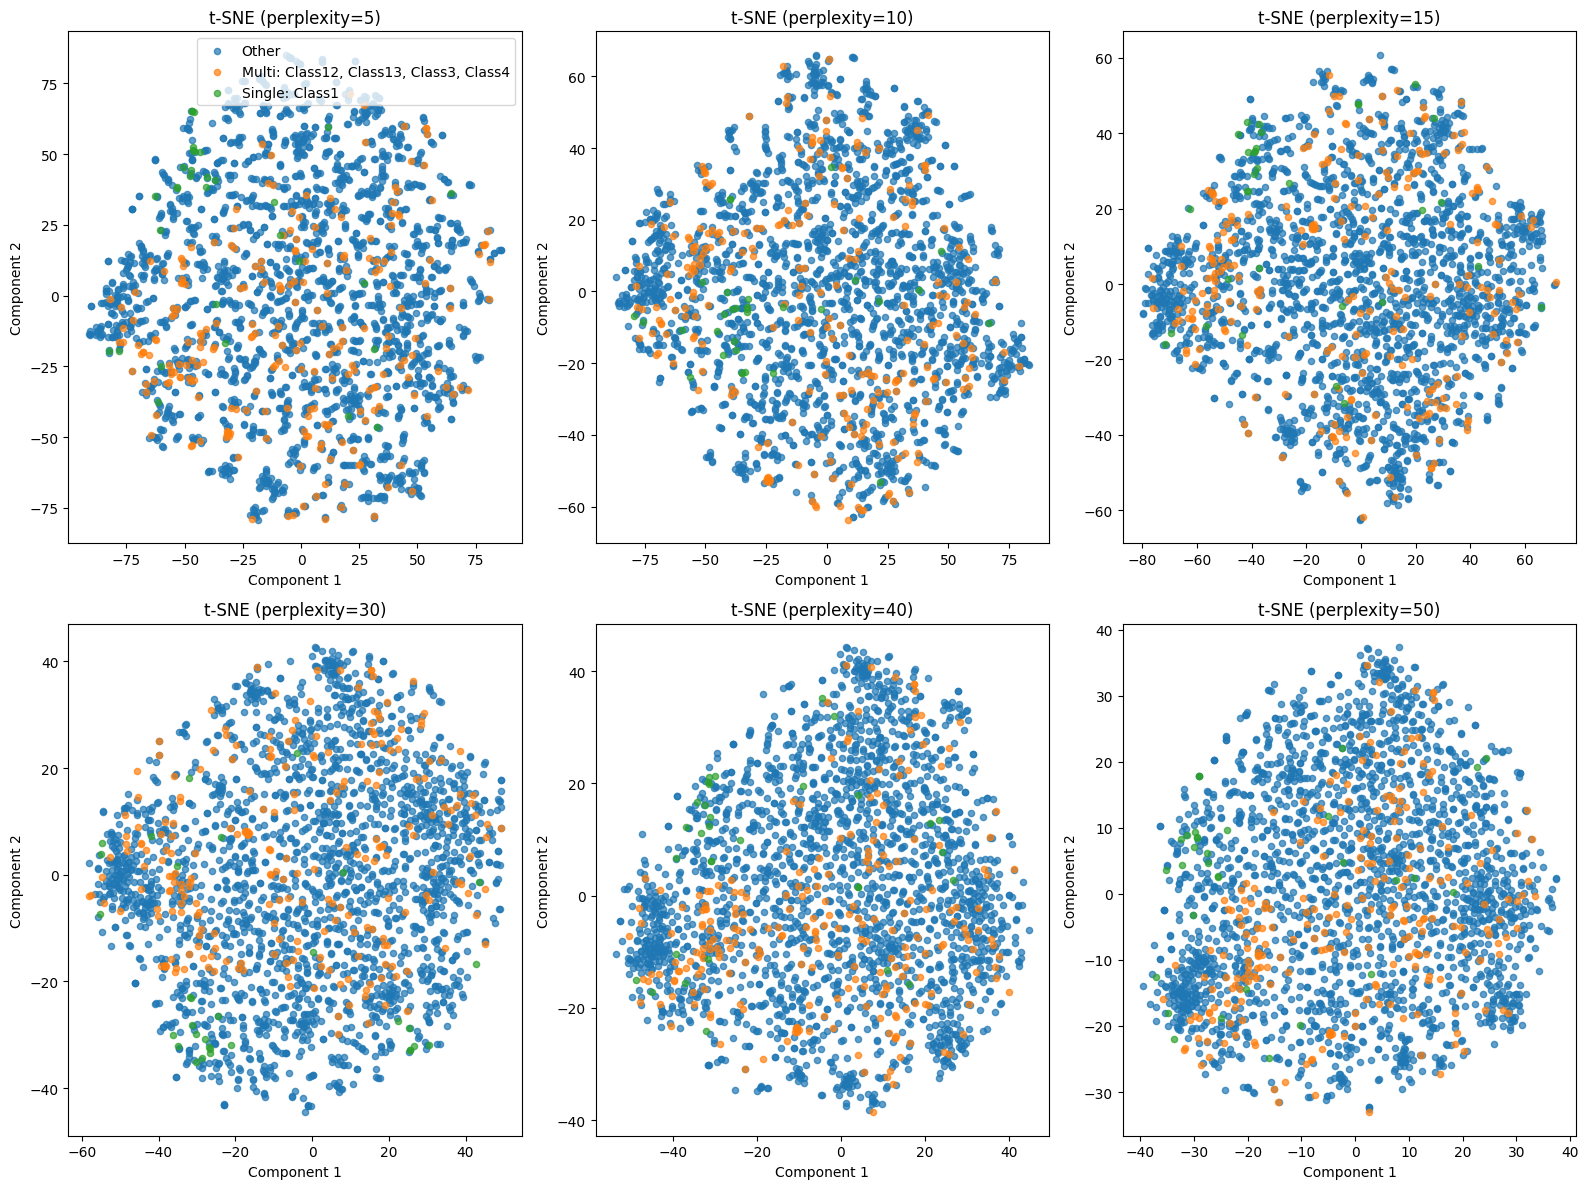

In [15]:
# Applying t-SNE with different perplexity values using visualization categories
perplexities = [5, 10, 15, 30, 40, 50]

plt.figure(figsize=(16, 12))

for i, perplexity in enumerate(perplexities, 1):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    plt.subplot(2, 3, i)
    for category in visualization_category.unique():
        mask = visualization_category == category
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   label=category, alpha=0.7, s=20)
    plt.title(f't-SNE (perplexity={perplexity})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    if i == 1:  # Only show legend on first plot to avoid repetition
        plt.legend()

plt.tight_layout()
plt.show()

#### **t-SNE Behavior with Different Perplexity Values**

- **Perplexity = 5:** Points are very spread out. Clusters look messy and disconnected, with many small isolated groups. The algorithm focuses too much on very close neighbors, so the overall structure is unclear.

- **Perplexity = 10:** Clusters start to form, but there is still some fragmentation. Noise is a little less, but the overall shape is still not clear.

- **Perplexity = 15:** Clusters become smoother and nearby points group together better. The balance between local and global structure improves, and clusters are easier to see.

- **Perplexity = 30:** The overall structure is clearer. Clusters are more compact with little overlap, giving a good balance between local neighborhoods and global shape.

- **Perplexity = 40:** Clusters start to merge slightly. The global structure is more visible, but some small local details are lost.

- **Perplexity = 50:** Points form a dense cloud. Classes mix together, and small local differences are not clear. The perplexity is too high for showing local structure.


The t-SNE visualization with perplexity ≈ 30 provides the most meaningful separation of the three label groups. It captures both local cluster details and global structure without excessive noise or overlap.

#### 2. t-SNE Visualization

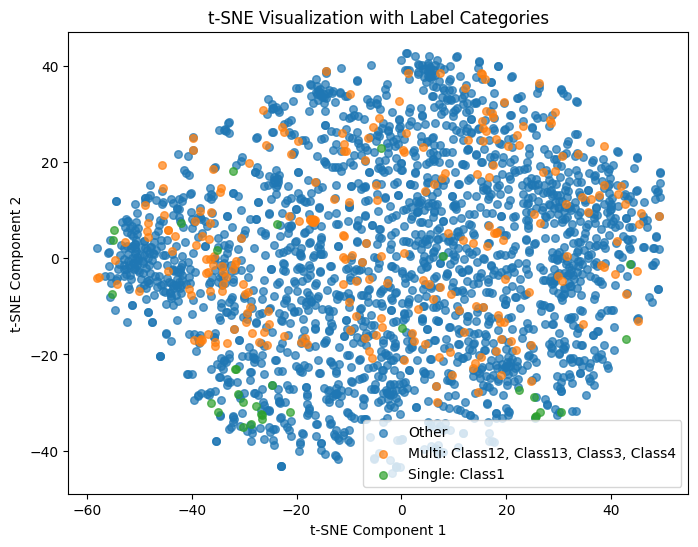

In [16]:
# Applying final t-SNE with chosen perplexity
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create colored scatter plot
plt.figure(figsize=(8, 6))
for category in visualization_category.unique():
    mask = visualization_category == category
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                label=category, alpha=0.7, s=30)
plt.title('t-SNE Visualization with Label Categories')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

#### 3. Veracity Inspection

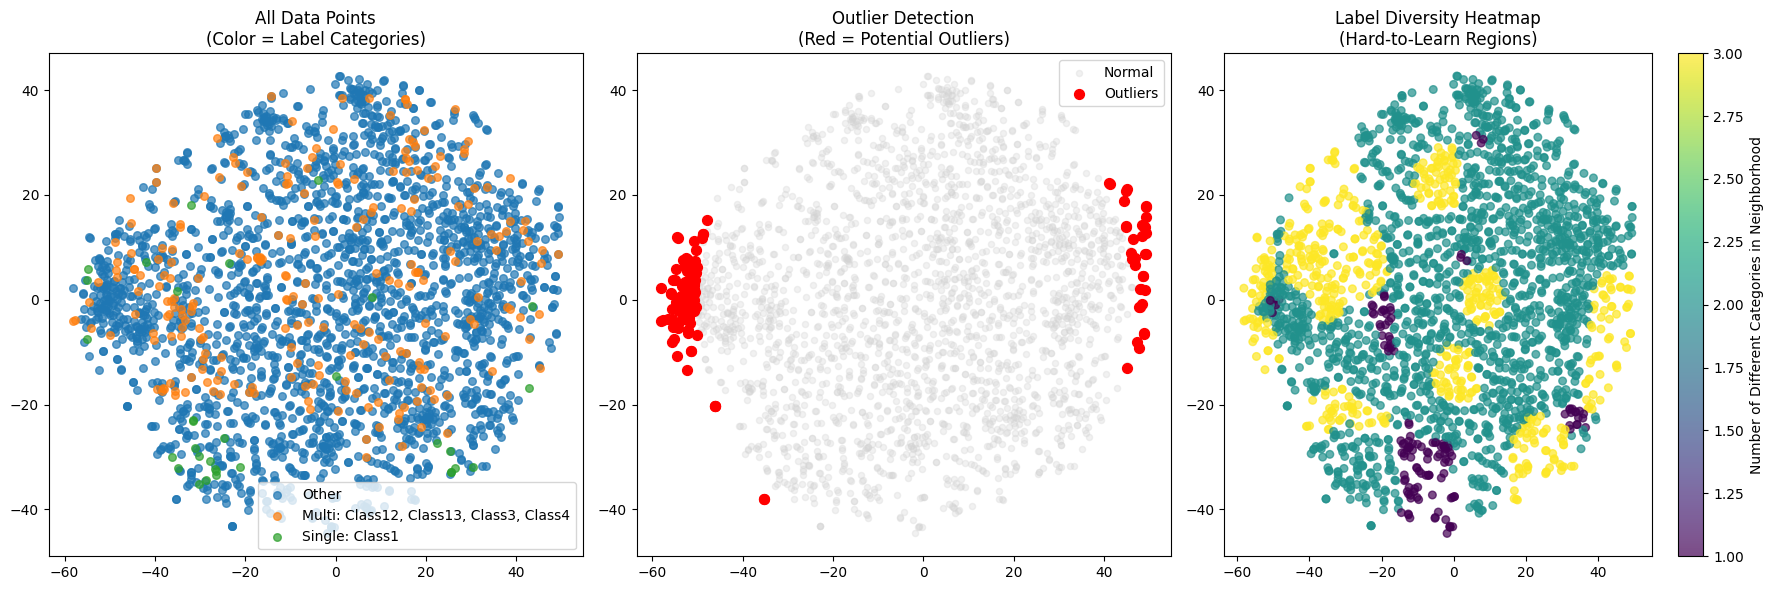

Outliers detected: 121
High diversity regions: 0


In [17]:
# Creating subplots for different veracity issues
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 1. All points colored by category
for category in visualization_category.unique():
    mask = visualization_category == category
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=category, alpha=0.7, s=30)
ax1.set_title('All Data Points\n(Color = Label Categories)')
ax1.legend()

# 2. Highlighting outliers
distances = np.sqrt(np.sum((X_tsne - np.mean(X_tsne, axis=0)) ** 2, axis=1))
outlier_threshold = np.percentile(distances, 95)
outlier_mask = distances > outlier_threshold

ax2.scatter(X_tsne[~outlier_mask, 0], X_tsne[~outlier_mask, 1], 
            c='lightgray', alpha=0.3, s=20, label='Normal')
ax2.scatter(X_tsne[outlier_mask, 0], X_tsne[outlier_mask, 1], 
            c='red', s=50, label='Outliers')
ax2.set_title('Outlier Detection\n(Red = Potential Outliers)')
ax2.legend()

# 3. Highlighting mixed regions (hard-to-learn)
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=50).fit(X_tsne)
distances, indices = nbrs.kneighbors(X_tsne)

label_diversity = []
for i in range(len(X_tsne)):
    neighbor_categories = visualization_category.iloc[indices[i]]
    unique_categories = neighbor_categories.nunique()
    label_diversity.append(unique_categories)

ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_diversity, 
           cmap='viridis', alpha=0.7, s=30)
ax3.set_title('Label Diversity Heatmap\n(Hard-to-Learn Regions)')
plt.colorbar(ax3.collections[0], ax=ax3, label='Number of Different Categories in Neighborhood')

plt.tight_layout()
plt.show()

print(f"Outliers detected: {outlier_mask.sum()}")
print(f"High diversity regions: {sum(d > 3 for d in label_diversity)}")

#### **1. All Data Points (Noisy / Ambiguous Labels)**

- Orange *Multi* and green *Single* samples appear embedded within blue *Other* clusters, suggesting possible **label noise** or **ambiguous boundaries**.  
- These mixed regions indicate samples whose features resemble other categories — potential **mislabels** or **borderline cases**.


#### **2. Outlier Detection**

- Red points on the far left and right edges are **isolated outliers**, far from the main data distribution.  
- They may represent **rare patterns**, **anomalies**, or **data collection artifacts** distinct from typical samples.


#### **3. Hard-to-Learn Regions**

- Bright yellow areas show regions with **high label diversity**, where multiple classes coexist closely.  
- These regions are **hard to classify**, as nearby samples belong to different labels, leading to **overlapping decision boundaries**.


### Part C: Isomap and Manifold Learning

#### 1. Isomap Implementation

In [18]:
isomap = Isomap(n_components=2, n_neighbors=15)
X_isomap = isomap.fit_transform(X_scaled)

print("Isomap completed!")
print(f"Isomap shape: {X_isomap.shape}")

print("\nFundamental difference between Isomap and t-SNE:")
print("Isomap: Preserves GLOBAL structure (geodesic distances)")
print("t-SNE: Preserves LOCAL structure (neighborhood probabilities)")

Isomap completed!
Isomap shape: (2417, 2)

Fundamental difference between Isomap and t-SNE:
Isomap: Preserves GLOBAL structure (geodesic distances)
t-SNE: Preserves LOCAL structure (neighborhood probabilities)


#### **Isomap (Global Structure Preserving)**

- **Preserves geodesic distances:** Focuses on maintaining distances between all pairs of points.  
- **Captures global geometry:** Retains the overall shape of the dataset (e.g., the manifold structure).  
- **Maintains long-range relationships:** Points that are far apart in high dimensions remain far apart in the low-dimensional embedding.


#### **t-SNE (Local Structure Preserving)**

- **Preserves local neighborhoods:** Focuses on the similarity between nearby points.  
- **Captures local structure well:** Ensures clusters of similar points stay together.  
- **Global distances may be distorted:** Points far apart in high dimensions may not reflect their true separation.


#### 2. Isomap Visualization

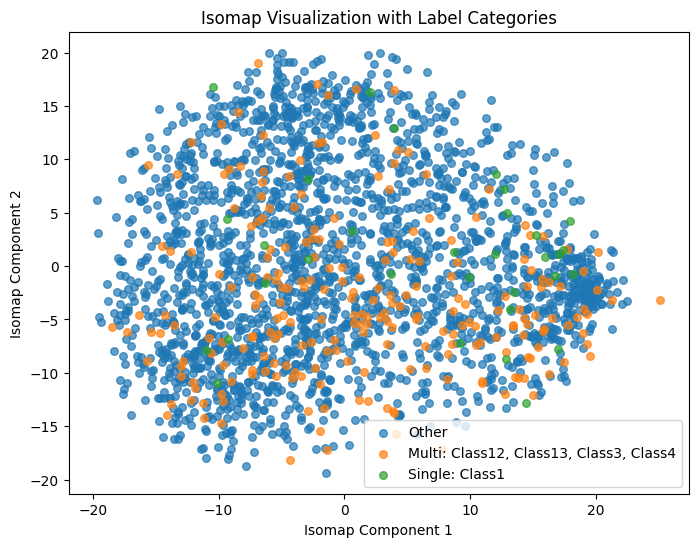

In [19]:
# Creating scatter plot with same coloring scheme
plt.figure(figsize=(8, 6))
for category in visualization_category.unique():
    mask = visualization_category == category
    plt.scatter(X_isomap[mask, 0], X_isomap[mask, 1], 
                label=category, alpha=0.7, s=30)
plt.title('Isomap Visualization with Label Categories')
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.legend()
plt.show()

#### 3. Comparison and Curvature 

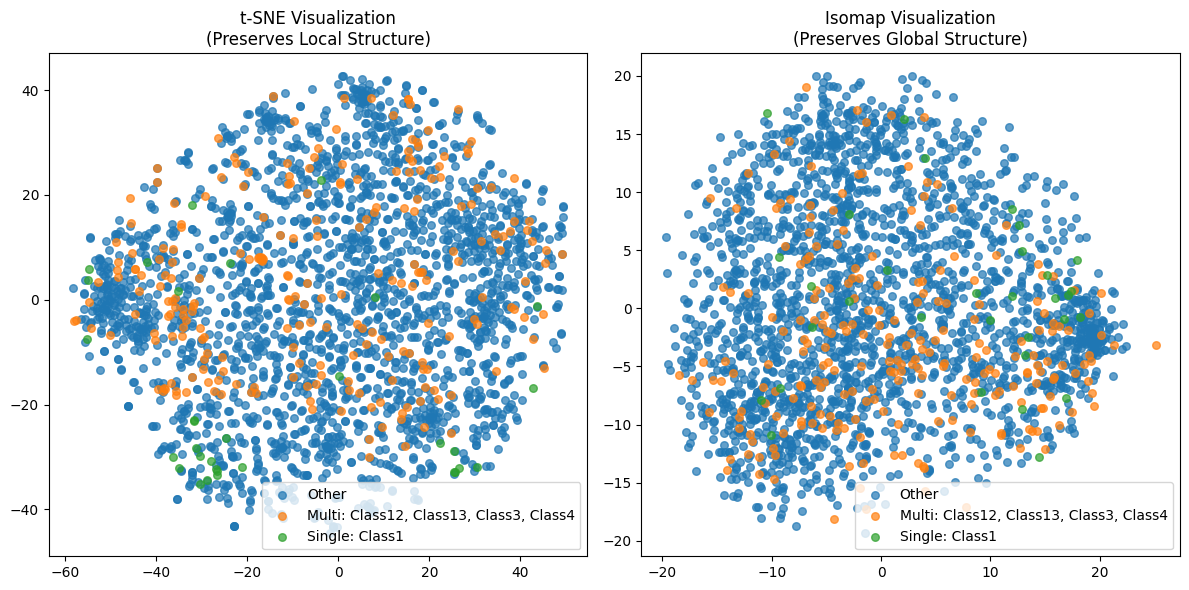

In [20]:
# Creating side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# t-SNE plot
for category in visualization_category.unique():
    mask = visualization_category == category
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=category, alpha=0.7, s=30)
ax1.set_title('t-SNE Visualization\n(Preserves Local Structure)')

# Isomap plot
for category in visualization_category.unique():
    mask = visualization_category == category
    ax2.scatter(X_isomap[mask, 0], X_isomap[mask, 1], label=category, alpha=0.7, s=30)
ax2.set_title('Isomap Visualization\n(Preserves Global Structure)')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

### **Comparing Isomap and t-SNE Visualizations**

Looking at both visualizations, **Isomap** is better at showing the global structure of the gene expression data.  


#### **Isomap (Right Plot)**
- Data points form a more uniform, spherical distribution.  
- Distances between clusters are more consistent across the plot.  
- The three categories (**Other**, **Multi**, **Single**) are evenly spread.  
- Global geometric relationships are better preserved — clusters appear at similar scales.  
- The overall structure is symmetric and balanced.


#### **t-SNE (Left Plot)**
- Clusters appear fragmented and separated.  
- Local groupings are very distinct, with clear gaps between clusters.  
- Distribution looks stretched and irregular.  
- Excels at showing local neighborhoods, but global distances are distorted.  

####
- **Isomap** preserves global structure by keeping geodesic distances across the dataset, showing a coherent overall shape with consistent spacing.  
- **t-SNE** highlights local clusters and fine details but can distort global distances and create misleading gaps.


#### **Conclusion**
For understanding the **overall global structure** and true geometric relationships in gene expression data, **Isomap** provides a more accurate representation.


### **Data Manifold Analysis from Isomap**

A **data manifold** is the underlying lower-dimensional structure that high-dimensional data naturally occupies in feature space.


#### **Manifold Complexity**
- The Isomap plot suggests a **relatively simple, smoothly curved manifold** rather than a highly complex one.  
- Data forms a cohesive, roughly **spherical distribution** without severe folds, tight spirals, or abrupt discontinuities.  
- Transitions between regions appear **gradual and continuous**.


#### **Relation to Classification Difficulty**
- The smooth manifold geometry is favorable for classification — standard ML algorithms work well on such structures.  
- Visualization shows **substantial overlap and intermixing** of the three classes (**Other**, **Multi**, **Single**).  
- Moderate classification difficulty arises not from geometric complexity, but from **intrinsic similarity between classes** in the gene expression space.  
- Classes are **not linearly separable**, requiring **non-linear classifiers**.  
- Smooth manifold means **moderately complex models** (e.g., SVMs, random forests) should perform reasonably well without needing architectures for highly complex manifolds.
